# SnS Solar Cell Example
This example is meant to follow the analysis done in [this paper](https://www.sciencedirect.com/science/article/pii/S254243511730096X), albeit at a lower resolution to demonstrate one level of grid subdivision as well as make it tractable to run in a few minutes on a personal computer.

## Introduction
In this example, we're using temperature- and light-intensity-dependent current-voltage measurements ($J(V,T,i)$) of a tin monosulfide (SnS) solar cell to fit four properties of the material and interfaces:

1. The band offset $\Delta E_c$ between the SnS and the Zn(O,S) buffer layer
2. The surface recombination velocity $S_{\text{eff}}$ at the SnS/Zn(O,S) interace
3. The minority carrier (electron) mobility $\mu$ in the SnS absorber
4. The minority carrier lifetime $\tau$ in the SnS absorber

We use [SCAPS](http://scaps.elis.ugent.be) for our device model, and simulations have been precomputed and stored in this example folder.

## Setup
First, we import some modules. **This may produce a few warnings on import (e.g. if you're running in Binder) but all the code should run correctly.**

In [1]:
# import some code that we'll need
import numpy as np
import sys
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd
from helper_fcns import *
import matplotlib.pyplot as plt
%matplotlib inline

Next, we initialize the ``bayesim`` model object. We provide the paths to the observed and modeled data as well as specifying the output variable name and preferred variable for x-axis plotting (`keep_all=True` tells ``bayesim`` not to discard any observation points). In addition, we'll calculate the model uncertainty during this step by setting `calc_model_unc=True`.

In [2]:
m = bym.Model(obs_data_path='obs_data.h5', model_data_path='sim_data_sparse.h5', output_var='J', keep_all=True,
              ec_x_var='V', calc_model_unc=True)

Determining experimental conditions from observed data...
Identified experimental conditions as ['V', 'T', 'ill']. (If this is wrong, rerun and explicitly specify them with attach_ec (make sure they match data file columns) or remove extra columns from data file.)
Determining fitting parameters from modeled data...
Found fitting parameters: ['dEc', 'S_eff', 'mu', 'tau']
Rounding model data...


Now we'll add some more information about our parameters to make plots look better...

In [3]:
m.set_param_info('V', units='V')
m.set_param_info('T', units='K')
m.set_param_info('J', units='mA/cm$^2$')
m.set_param_info('dEc', units='eV', display_name='$\Delta$ E$_c$')
m.set_param_info('S_eff', units='cm/s', display_name='S$_{\mathrm{eff}}$')
m.set_param_info('tau', units='ns', display_name=r'$\tau$')
m.set_param_info('mu', units='cm$^2$/Vs', display_name='$\mu$')

## Inference round one
This run should take ~20 seconds.

In [4]:
m.run()

Did a total of 77 runs to use a total of 84 observations.

An average of 291 / 400 probability points had larger model uncertainty than experimental uncertainty during this run.

An average of 0.31 / 400 probability points were affected by missing/NaN simulation data.


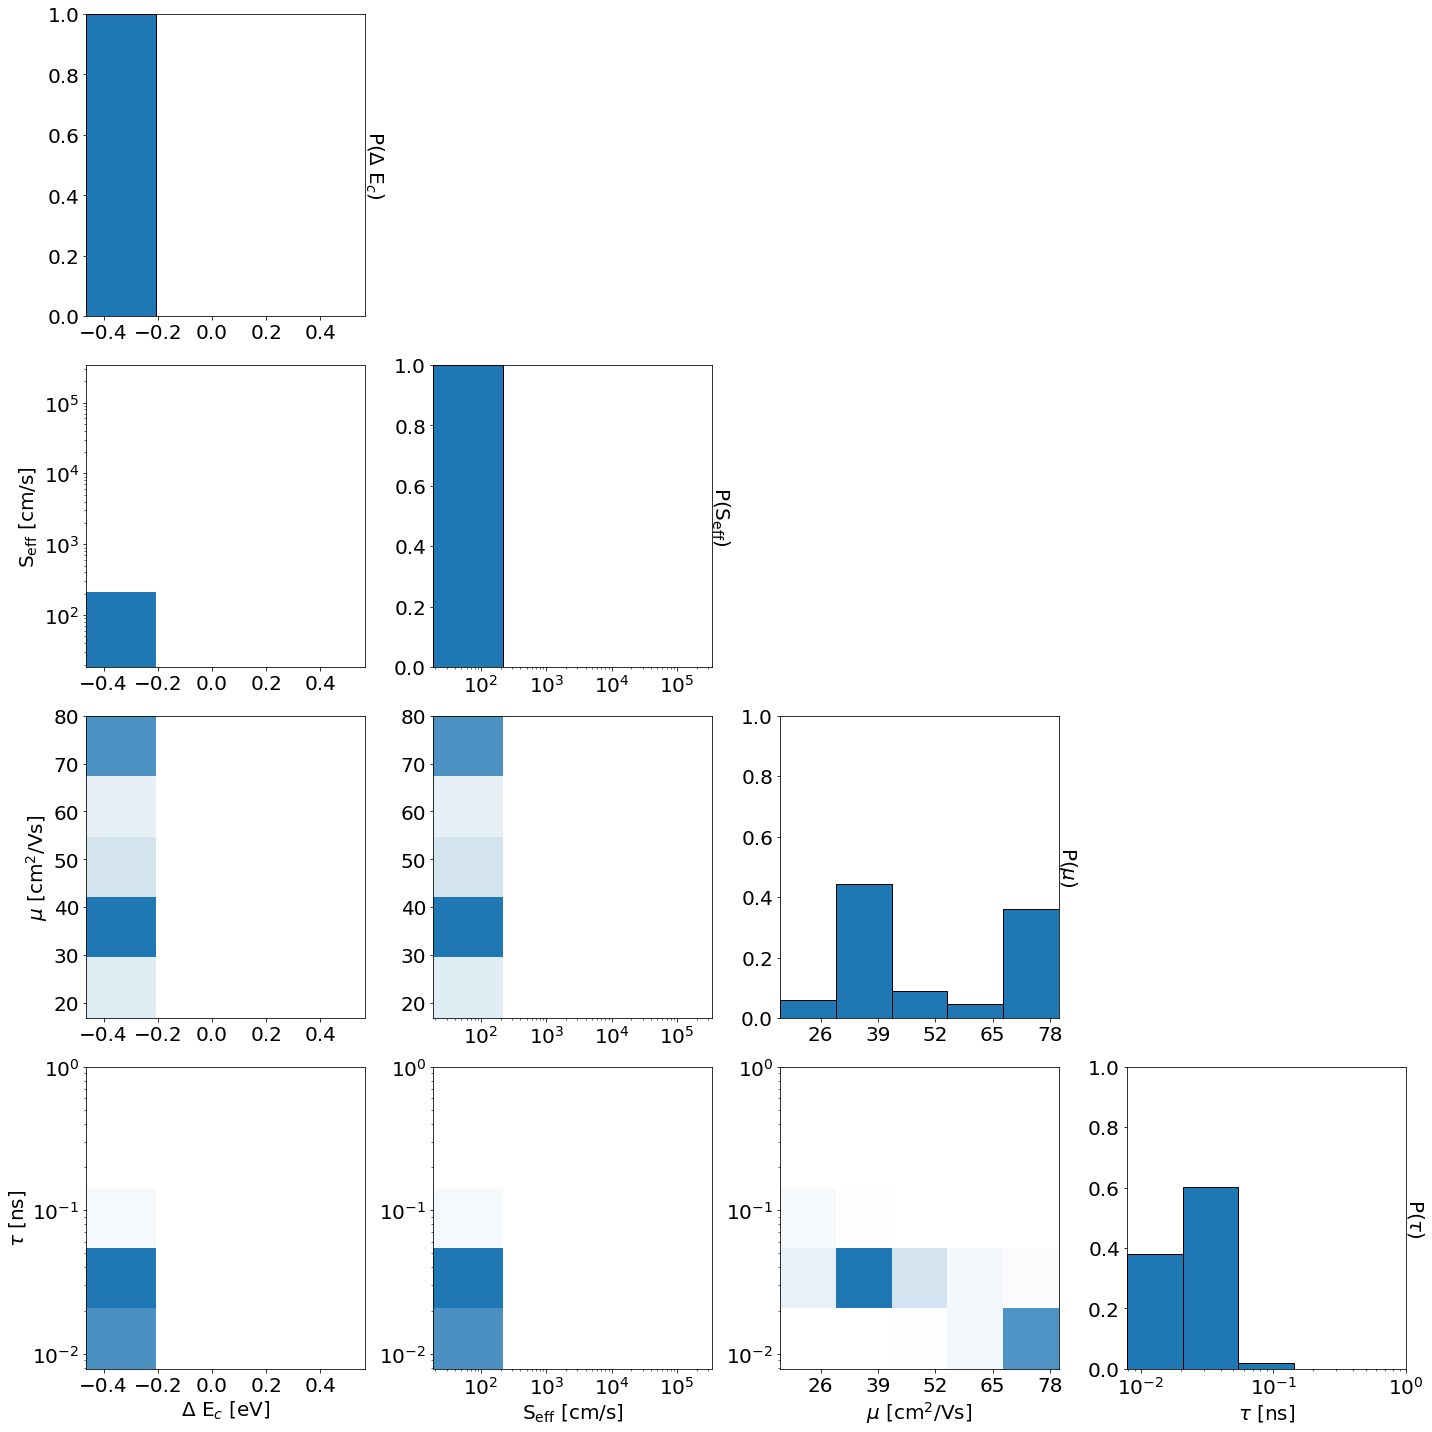

In [6]:
m.visualize_probs()

## Subdivide the grid
Subdivide and take a look at the grid.

In [7]:
m.subdivide()

10 box(es) with probability > 0.001 and 61 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_1.h5.


Showing the grid takes ~20 seconds...it will be sped up in a future version.

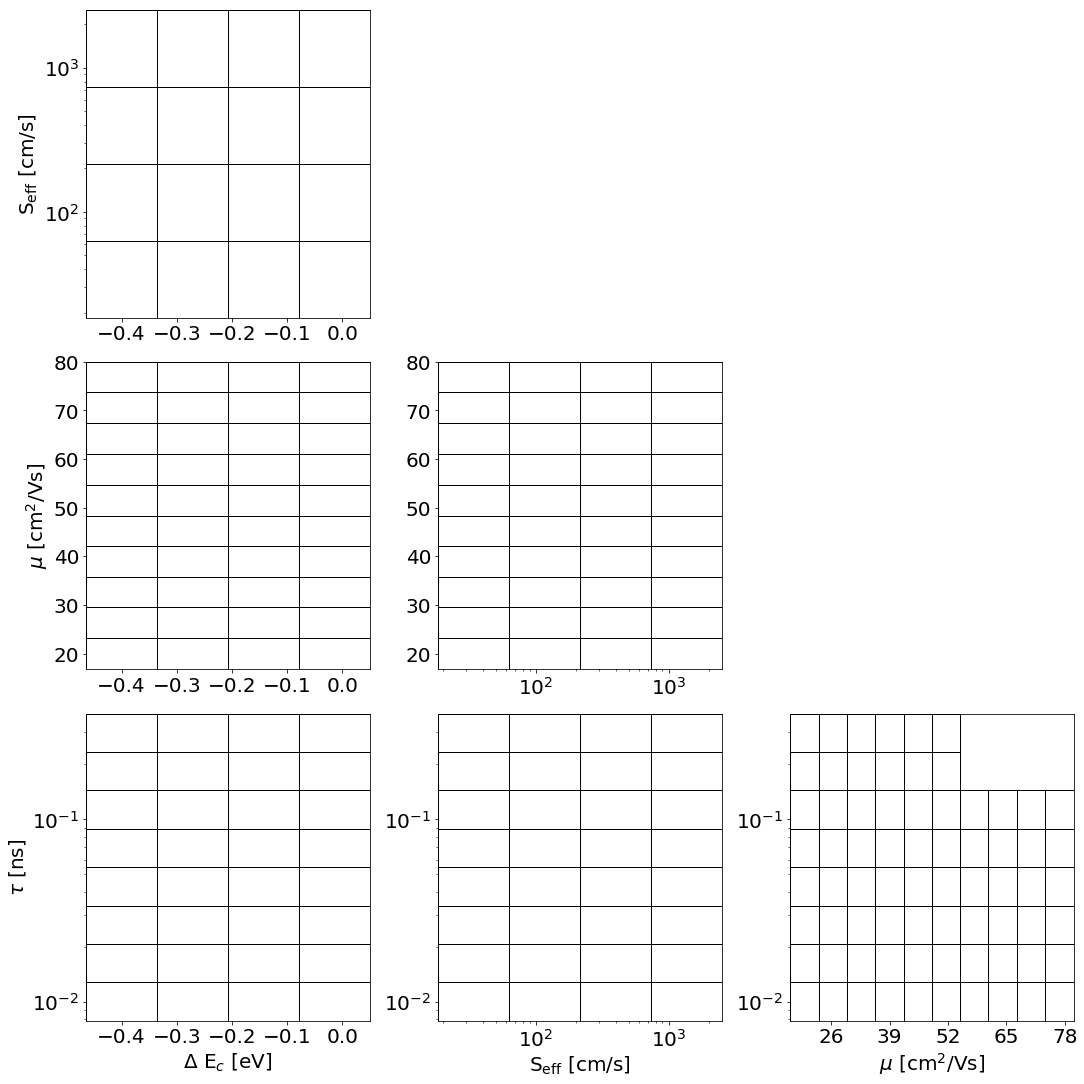

In [8]:
m.visualize_grid()

## Get more model data and run inference again
The `get_new_data` function is defined in `helper_fcns.py` that was imported at the top and just pulls out the new data points we need from the larger data file (`sim_data_less_sparse.h5.zip`). Then we attach that new data to the ``bayesim`` model object.

This cell takes about a minute.

In [9]:
# pull the data we need from it and attach
get_new_data(m, 'new_sim_points_1.h5', 'new_sim_data.h5')
m.attach_model(mode='file', model_data_path='new_sim_data.h5', calc_model_unc=True)

Rounding model data...


In this inference run we'll insist upon using all the observed data points by setting `min_num_pts=len(m.obs_data)` and also set stricter criteria for probability mass concentration.

This cell also takes about a minute to evaluate.

In [10]:
m.run(min_num_pts=len(m.obs_data), th_pv=0.01, th_pm=0.99)

Used all the observed data! Last PMF to go into average may have been further from threshold condition.
Did a total of 1 runs to use a total of 120 observations.

An average of 483 / 1136 probability points had larger model uncertainty than experimental uncertainty during this run.

An average of 0.17 / 1136 probability points were affected by missing/NaN simulation data.


In [ ]:
m.visualize_probs()

Compare to:
![PMF from Joule paper](https://github.com/PV-Lab/bayesim/blob/master/docs/img/SnS_probs.png?raw=true "PMF from dense grid sampling")
Not bad!

## Compare modeled and observed data

In [ ]:
m.comparison_plot(num_param_pts=2, num_ecs=3)